In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

In [ ]:
# pip install matplotlib numpy jupyter torch torchvision

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2861,), (0.3530,))
])

Next we'll load the MNIST data. First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for validation, instead of for testing the final model.

In [ ]:
train_dataset = FashionMNIST('../datasets',
                               train=True,
                               download=True,
                               transform=transform)

validation_dataset = FashionMNIST('../datasets',
                                    train=False,
                                    transform=transform)

100%|██████████| 26421880/26421880 [00:08<00:00, 3268452.92it/s] 


Extracting ../datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173585.68it/s]


Extracting ../datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1256278.39it/s]


Extracting ../datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15152475.08it/s]

Extracting ../datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/FashionMNIST/raw



In [ ]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

validation_loader = DataLoader(dataset=validation_dataset, shuffle=False)

## EDA

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

And the first training images.

In [ ]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.2861,), std=(0.353,))
           )

In [ ]:
validation_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../datasets
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.2861,), std=(0.353,))
           )

In [ ]:
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
len(train_dataset.classes)

10

In [ ]:
train_dataset.data.size()

torch.Size([60000, 28, 28])

In [ ]:
train_dataset.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [ ]:
unique_arrays, indices = torch.unique(train_dataset.data, dim=0, return_inverse=True)

counts = torch.bincount(indices)

repeated_arrays = unique_arrays[counts > 1]

if repeated_arrays.numel() > 0:
    print("Однакові масиви у тензорі:")
    for arr in repeated_arrays:
        print(arr)
else:
    print("Немає однакових масивів.")

Немає однакових масивів.


X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


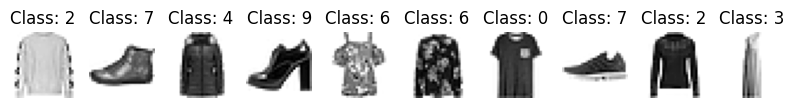

In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())

    pltsize = 1
    plt.figure(figsize=(10 * pltsize, pltsize))

    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.axis('off')
        plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r")
        plt.title('Class: ' + str(y_train[i].item()))

    break

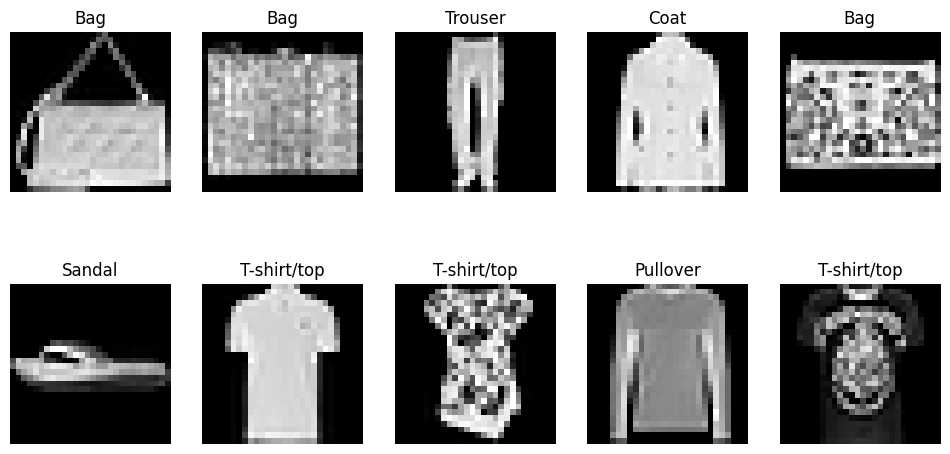

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Function to plot images
def plot_images(images, labels, classes):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.show()

# Define class names
classes = train_dataset.classes

# Plot sample images
images, labels = next(iter(train_loader))
plot_images(images, labels, classes)

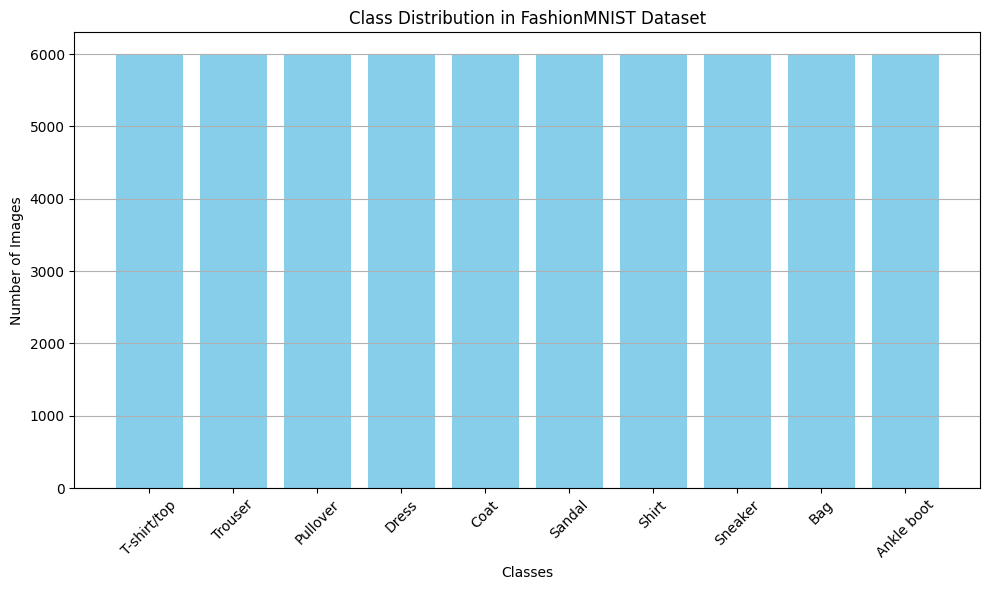

In [ ]:
from collections import Counter
labels = np.array(train_dataset.targets)
class_counts = Counter(labels)
counts = [class_counts[i] for i in range(len(classes))]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.title('Class Distribution in FashionMNIST Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


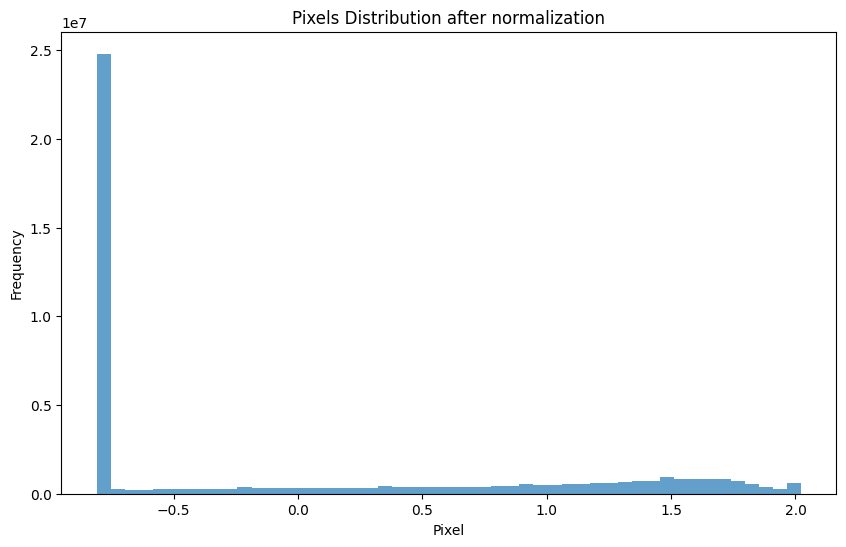

In [ ]:
import numpy as np

pixel_values = []

for images, labels in train_loader:
    images = images.numpy()
    pixel_values.extend(images.flatten())

pixel_values = np.array(pixel_values)
plt.figure(figsize=(10,6))
plt.hist(pixel_values, bins=50, alpha=0.7)
plt.xlabel('Pixel')
plt.ylabel('Frequency')
plt.title('Pixels Distribution after normalization')
plt.show()

## Models

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, scheduler=None):
    model.train()  # Set the model to training mode
    epoch_losses = []  # To store the loss for each epoch
    epoch_accuracies = []  # To store the accuracy for each epoch

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            # Move data to the device (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for the epoch
        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total

        # Append to lists
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)

        if scheduler is not None:
          scheduler.step()

        # Print statistics for the current epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return epoch_losses, epoch_accuracies


In [ ]:
def validate_model(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in val_loader:
            # Move data to the device (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update running loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            all_preds.append(predicted.numpy())
            all_labels.append(labels.numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for the epoch
        avg_loss = running_loss / len(val_loader)
        accuracy = 100 * correct / total

        # Print statistics for the validation set
        print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return avg_loss, accuracy, np.concatenate(all_labels), np.concatenate(all_preds)


In [ ]:
def plot_confusion_matrix(y_act, y_pred):
  confusion_mat = confusion_matrix(y_act, y_pred)

  # Plot confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title('Confusion Matrix')
  plt.show()

In [ ]:
def plot_validation_metrics(epochs, val_losses, val_accuracies):
    plt.figure(figsize=(10, 5))

    # Subplot for validation loss
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
    plt.plot(np.arange(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Subplot for validation accuracy
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
    plt.plot(np.arange(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

### Multilayer Perceptron / Feed Forward NN

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
simple_mlp_model = SimpleMLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_mlp_model.parameters(), lr=0.005)

In [ ]:
simple_mlp_model

SimpleMLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
smlp_tloss, smlp_tacc = train_model(simple_mlp_model, train_loader, criterion, optimizer, 20)

Epoch [1/20], Loss: 0.2758, Accuracy: 89.87%
Epoch [2/20], Loss: 0.2640, Accuracy: 90.24%
Epoch [3/20], Loss: 0.2530, Accuracy: 90.69%
Epoch [4/20], Loss: 0.2434, Accuracy: 90.96%
Epoch [5/20], Loss: 0.2356, Accuracy: 91.36%
Epoch [6/20], Loss: 0.2273, Accuracy: 91.59%
Epoch [7/20], Loss: 0.2195, Accuracy: 91.78%
Epoch [8/20], Loss: 0.2124, Accuracy: 92.07%
Epoch [9/20], Loss: 0.2059, Accuracy: 92.29%
Epoch [10/20], Loss: 0.1989, Accuracy: 92.60%
Epoch [11/20], Loss: 0.1930, Accuracy: 92.76%
Epoch [12/20], Loss: 0.1861, Accuracy: 93.05%
Epoch [13/20], Loss: 0.1802, Accuracy: 93.15%
Epoch [14/20], Loss: 0.1735, Accuracy: 93.49%
Epoch [15/20], Loss: 0.1693, Accuracy: 93.67%
Epoch [16/20], Loss: 0.1649, Accuracy: 93.90%
Epoch [17/20], Loss: 0.1597, Accuracy: 94.04%
Epoch [18/20], Loss: 0.1544, Accuracy: 94.30%
Epoch [19/20], Loss: 0.1494, Accuracy: 94.45%
Epoch [20/20], Loss: 0.1439, Accuracy: 94.71%


In [ ]:
smlp_vloss, smlp_vacc, smlp_y_act, smlp_y_pred = validate_model(simple_mlp_model, validation_loader, criterion)
print(classification_report(smlp_y_act, smlp_y_pred))

Validation Loss: 0.3607, Accuracy: 88.82%
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.81      0.84      0.82      1000
           3       0.90      0.87      0.88      1000
           4       0.82      0.82      0.82      1000
           5       0.98      0.94      0.96      1000
           6       0.73      0.68      0.70      1000
           7       0.93      0.98      0.95      1000
           8       0.96      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



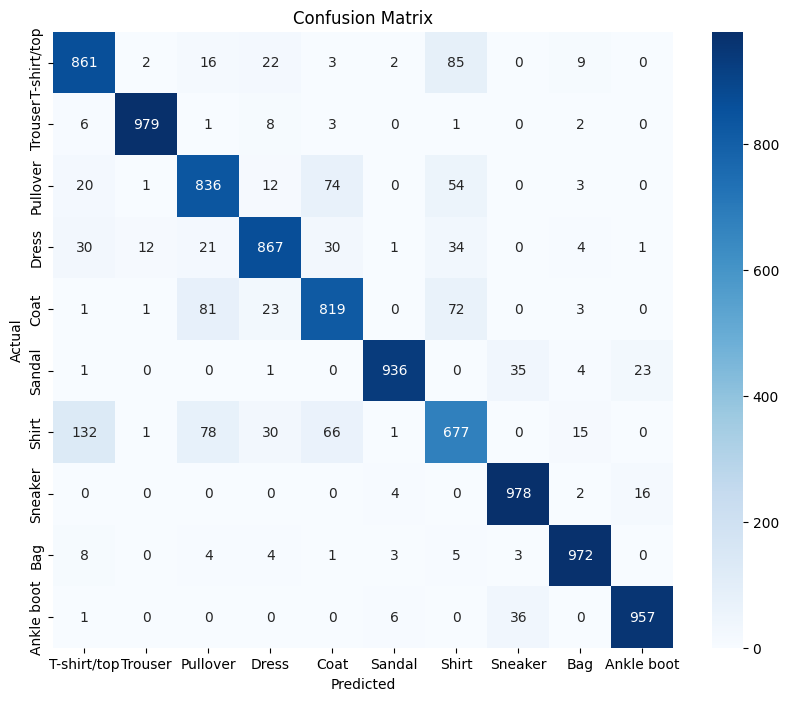

In [ ]:
plot_confusion_matrix(smlp_y_act, smlp_y_pred)

In [ ]:
leaky_relu = nn.LeakyReLU(negative_slope=0.01)

class SimpleMLP2(nn.Module):
    def __init__(self):
        super(SimpleMLP2, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = leaky_relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

In [ ]:
simple_mlp2_model = SimpleMLP2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(simple_mlp2_model.parameters(), lr=0.0000001)

# Learning rate scheduler: Decreases learning rate every 10 epochs by a factor of 0.1
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
smlp2_tloss, smlp2_tacc = train_model(simple_mlp2_model, train_loader, criterion, optimizer, 10)

Epoch [1/3], Loss: 0.1787, Accuracy: 93.05%
Epoch [2/3], Loss: 0.1792, Accuracy: 93.06%
Epoch [3/3], Loss: 0.1785, Accuracy: 93.06%


In [ ]:
smlp2_vloss, smlp2_vacc, smlp2_y_act, smlp2_y_pred = validate_model(simple_mlp2_model, validation_loader, criterion)
print(classification_report(smlp2_y_act, smlp2_y_pred))

Validation Loss: 0.5225, Accuracy: 88.78%
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1000
           1       0.98      0.97      0.98      1000
           2       0.83      0.80      0.81      1000
           3       0.88      0.88      0.88      1000
           4       0.80      0.82      0.81      1000
           5       0.96      0.96      0.96      1000
           6       0.71      0.73      0.72      1000
           7       0.93      0.96      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
class SimpleMLP2(nn.Module):
    def __init__(self):
        super(SimpleMLP2, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        return self.fc4(x)

In [ ]:
simple_mlp2_model = SimpleMLP2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(simple_mlp2_model.parameters(), lr=0.000001)  # important! change learning rate rapidly as the epochs go (and start of small-neutral)

In [ ]:
smlp2_tloss, smlp2_tacc = train_model(simple_mlp2_model, train_loader, criterion, optimizer, 4)

Epoch [1/4], Loss: 0.0927, Accuracy: 96.48%
Epoch [2/4], Loss: 0.0926, Accuracy: 96.49%
Epoch [3/4], Loss: 0.0920, Accuracy: 96.46%
Epoch [4/4], Loss: 0.0923, Accuracy: 96.47%


In [ ]:
smlp2_vloss, smlp2_vacc, smlp2_y_act, smlp2_y_pred = validate_model(simple_mlp2_model, validation_loader, criterion)
print(classification_report(smlp2_y_act, smlp2_y_pred))

Validation Loss: 0.5153, Accuracy: 89.69%
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.83      0.82      1000
           3       0.91      0.89      0.90      1000
           4       0.83      0.83      0.83      1000
           5       0.98      0.97      0.98      1000
           6       0.73      0.71      0.72      1000
           7       0.94      0.97      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



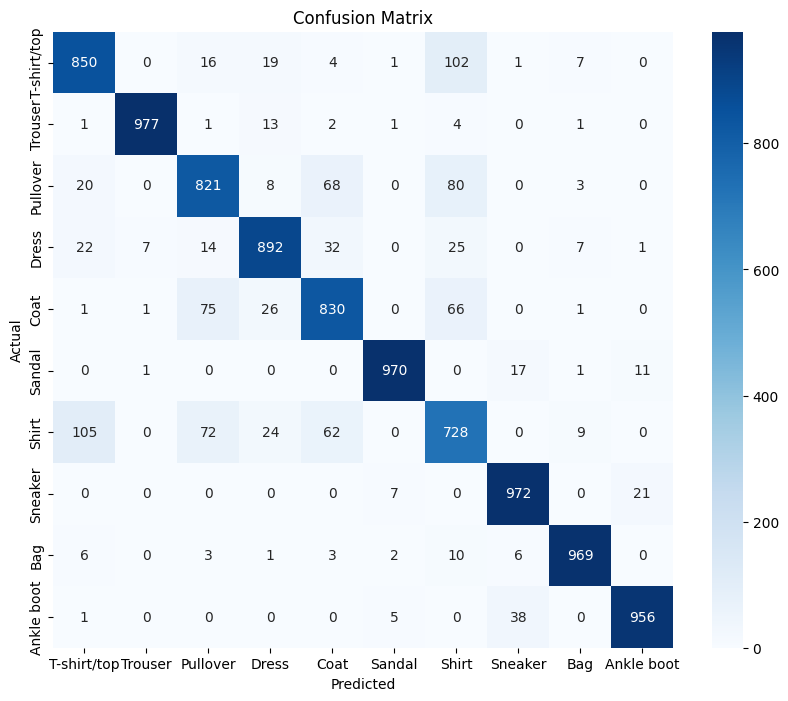

In [ ]:
plot_confusion_matrix(smlp2_y_act, smlp2_y_pred)

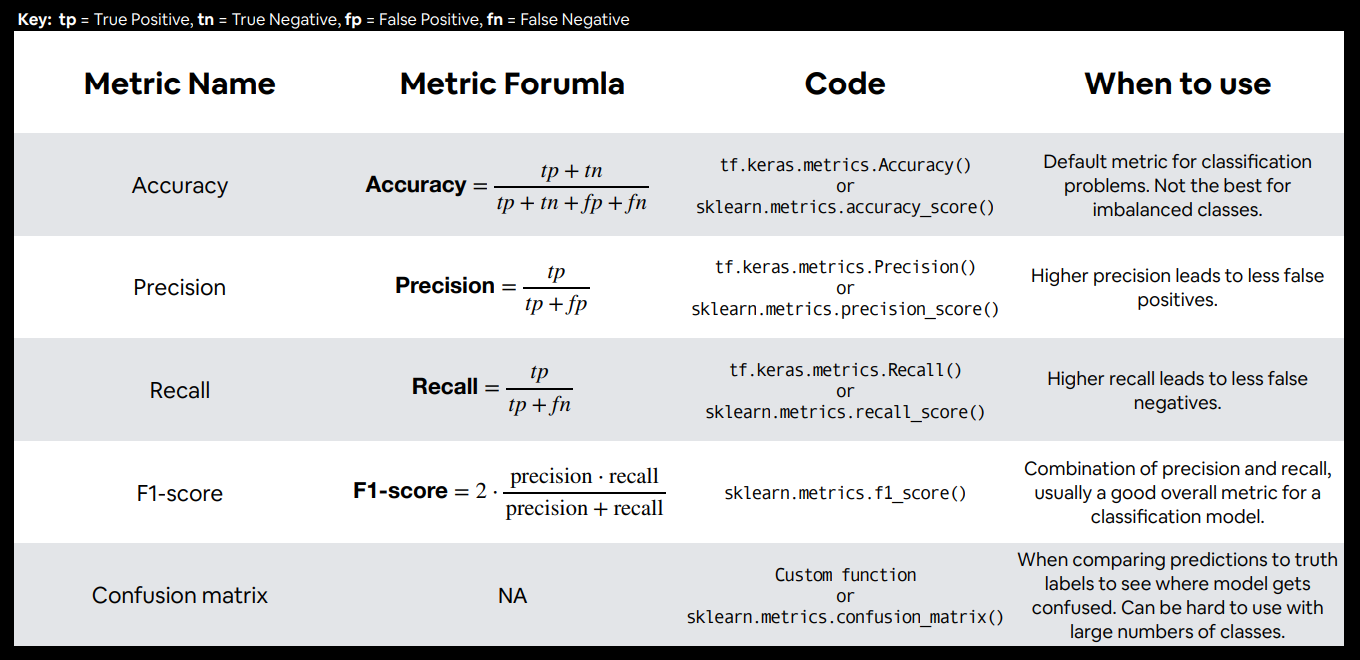

### Convolutional NN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = nn.MaxPool2d(kernel_size=2)(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = nn.MaxPool2d(kernel_size=2)(x)

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


The line x = nn.MaxPool2d(kernel_size=2)(x) applies a max pooling operation to the input tensor x, reducing its height and width by half while retaining the most significant features in each 2x2 block. This is a common practice in CNNs to help prevent overfitting and reduce computational complexity while maintaining important spatial features in the data.

Max pooling is a downsampling technique used primarily in Convolutional Neural Networks (CNNs) to reduce the spatial dimensions (height and width) of the input feature maps while retaining the most important features.

In [ ]:
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.005)

In [ ]:
cnn_model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
%%time
epochs = 5

cnn_vlosses, cnn_vaccs = [], []
for epoch in range(1, epochs + 1):
    train_model(cnn_model, train_loader, criterion, optimizer, epoch)
    cnn_vloss, cnn_vacc, cnn_y_act, cnn_y_pred = validate_model(cnn_model, validation_loader, criterion)
    cnn_vlosses.append(cnn_vloss)
    cnn_vaccs.append(cnn_vacc)

Epoch [1/1], Loss: 0.4306, Accuracy: 84.28%
Validation Loss: 0.3601, Accuracy: 87.21%
Epoch [1/2], Loss: 0.3162, Accuracy: 88.34%
Epoch [2/2], Loss: 0.2892, Accuracy: 89.37%
Validation Loss: 0.3030, Accuracy: 89.22%
Epoch [1/3], Loss: 0.2733, Accuracy: 89.83%
Epoch [2/3], Loss: 0.2615, Accuracy: 90.28%
Epoch [3/3], Loss: 0.2507, Accuracy: 90.65%
Validation Loss: 0.3139, Accuracy: 88.78%
Epoch [1/4], Loss: 0.2441, Accuracy: 90.90%
Epoch [2/4], Loss: 0.2365, Accuracy: 91.29%
Epoch [3/4], Loss: 0.2330, Accuracy: 91.29%
Epoch [4/4], Loss: 0.2267, Accuracy: 91.54%
Validation Loss: 0.3270, Accuracy: 89.46%


KeyboardInterrupt: 

Epoch [4/4], Loss: 0.2267, Accuracy: 91.54%

Validation Loss: 0.3270, Accuracy: 89.46%"

#### CNN + L2 Regularization, Early Stopping and Dropouts to prevent overfitting

In [ ]:
class CNN_DRE(nn.Module):
    def __init__(self):
        super(CNN_DRE, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = nn.MaxPool2d(kernel_size=2)(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = nn.MaxPool2d(kernel_size=2)(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=5):
    early_stopping = EarlyStopping(patience=patience)
    model.train()  # Set the model to training mode
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

        # Validation phase
        val_loss, val_accuracy, y_act, y_pred = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Early stopping check
        if early_stopping(val_loss):
            print(f'Early stopping at epoch {epoch+1}')
            break
    return val_losses, val_accuracies, y_act, y_pred


In [ ]:
cnn2_model = CNN_DRE()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn2_model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
%%time
epochs = 5

cnn_vlosses, cnn_vaccs = [], []
y_acts, y_preds = [], []
for epoch in range(1, epochs + 1):
    val_losses, val_accuracies, y_act, y_pred = train_model(cnn2_model, train_loader, validation_loader, criterion, optimizer, epoch)
    cnn_vlosses.append(val_losses[epoch-1])
    cnn_vaccs.append(val_accuracies[epoch-1])
    y_acts.append(y_act)
    y_preds.append(y_pred)

Epoch [1/1], Loss: 0.2713, Accuracy: 90.25%
Validation Loss: 0.2311, Accuracy: 91.77%
Epoch [1/2], Loss: 0.2595, Accuracy: 90.45%
Validation Loss: 0.2324, Accuracy: 91.28%
Epoch [2/2], Loss: 0.1569, Accuracy: 94.06%
Validation Loss: 0.2256, Accuracy: 91.90%
Epoch [1/3], Loss: 0.2610, Accuracy: 90.53%
Validation Loss: 0.2301, Accuracy: 91.45%
Epoch [2/3], Loss: 0.1389, Accuracy: 94.83%
Validation Loss: 0.2220, Accuracy: 92.19%
Epoch [3/3], Loss: 0.1237, Accuracy: 95.31%
Validation Loss: 0.2399, Accuracy: 91.59%
Epoch [1/4], Loss: 0.2592, Accuracy: 90.60%
Validation Loss: 0.2203, Accuracy: 92.01%
Epoch [2/4], Loss: 0.1137, Accuracy: 95.76%
Validation Loss: 0.2434, Accuracy: 92.03%
Epoch [3/4], Loss: 0.0995, Accuracy: 96.21%
Validation Loss: 0.2273, Accuracy: 92.37%
Epoch [4/4], Loss: 0.0887, Accuracy: 96.75%
Validation Loss: 0.2469, Accuracy: 92.07%
Epoch [1/5], Loss: 0.2722, Accuracy: 90.22%
Validation Loss: 0.2225, Accuracy: 92.23%
Epoch [2/5], Loss: 0.0860, Accuracy: 96.86%
Validation

In [ ]:
cnn_vlosses, cnn_vaccs

([[0.2310658986657693],
  [0.23244510853064784, 0.22562399893258345],
  [0.23014175975721932, 0.22196405810204298, 0.23988297308286638],
  [0.22026093250948556,
   0.24340675353179067,
   0.2273176029136609,
   0.24690102723124518],
  [0.22248528344974153,
   0.24613819959919983,
   0.27121743553793887,
   0.27399227822815664,
   0.2800814285771148]],
 [[91.77],
  [91.28, 91.9],
  [91.45, 92.19, 91.59],
  [92.01, 92.03, 92.37, 92.07],
  [92.23, 91.73, 91.72, 92.13, 92.25]])

In [ ]:
vlosses = []
for i in cnn_vlosses:
  vlosses.append(1-i[-1])

vaccs = []
for i in cnn_vaccs:
  vaccs.append(i[-1])

In [ ]:
print(classification_report(y_acts[epochs-1], y_preds[epochs-1]))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.87      0.90      0.88      1000
           3       0.93      0.91      0.92      1000
           4       0.88      0.89      0.88      1000
           5       0.97      0.98      0.98      1000
           6       0.78      0.78      0.78      1000
           7       0.96      0.97      0.97      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



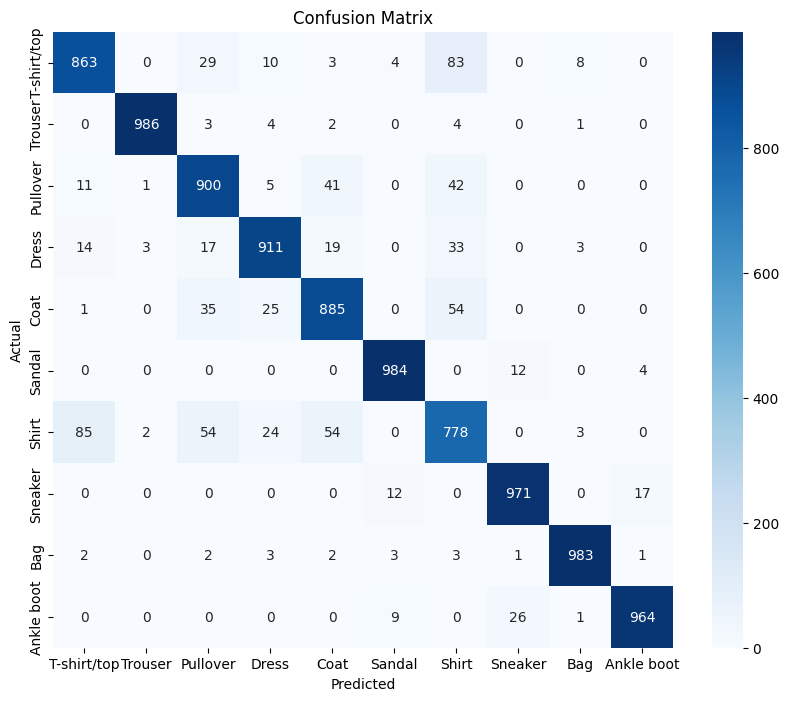

In [ ]:
plot_confusion_matrix(y_acts[epochs-1], y_preds[epochs-1])

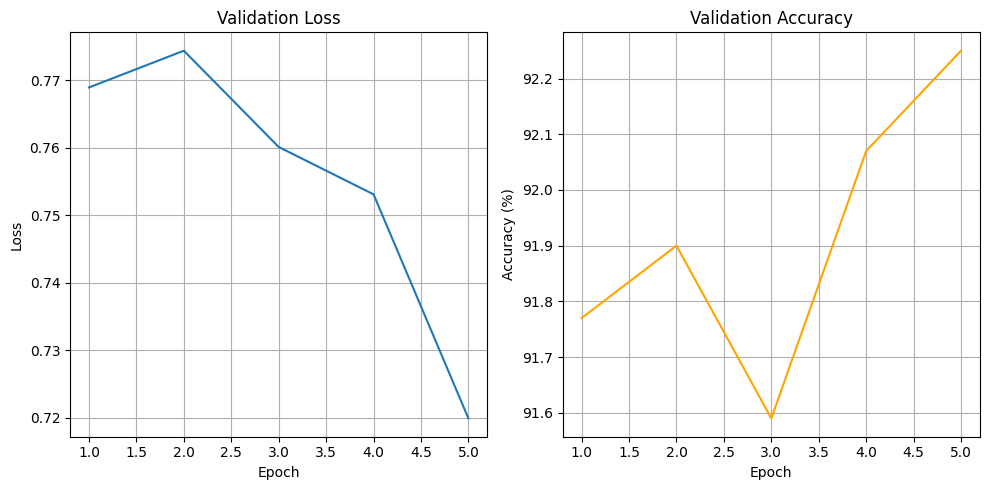

In [ ]:
plot_validation_metrics(epochs, vlosses, vaccs)

## Висновки



*   Зі збільшенням кількості шарів у моделі (глибокі нейронні мережі) можна виявити більш складні патерни в даних. Однак це також підвищує ризик перенавчання, оскільки модель може почати запам'ятовувати навчальні дані замість того, щоб навчитися загальних ознак.
*   Важливо знайти баланс між простотою моделі та її здатністю до навчання. Невелика кількість шарів може призвести до недостатньої потужності моделі.
*   Вибір кількості нейронів у кожному шарі впливає на здатність моделі до обробки інформації. Більша кількість нейронів дозволяє моделі зберігати більше інформації, але також збільшує обчислювальні витрати та ризик перенавчання.
*   Використання методів регуляризації (таких як L1, L2, dropout, early stopping) допомагає зменшити вплив надмірної складності моделі, контролюючи значення ваг. Це дозволяє уникнути перенавчання та покращити загальну здатність моделі до узагальнення.
*   Вибір активаційної функції вплине на те, як мережа обробляє дані. Наприклад, функція активації ReLU (Rectified Linear Unit) зазвичай використовується вглибоких мережах через свою здатність усувати проблему затухаючих градієнтів. Водночас, функції, такі як сигмоїда чи tanh, можуть бути менш ефективними в глибоких мережах через їхні обмеження в градієнтах.
*   Активаційні функції додають нелінійність до моделі, що дозволяє їй вчитися на складних патернах у даних. Вибір правильних активаційних функцій критично важливий для досягнення високих результатів.


---


Зміна кількості шарів, параметрів, вибір активаційних функцій та застосування регуляризації суттєво впливають на ефективність моделі в машинному навчанні. Важливо експериментувати з різними архітектурами та налаштуваннями, щоб знайти оптимальні комбінації для досягнення найкращих результатів у конкретних завданнях. Вибір належних методів і підходів дозволяє створювати потужні моделі, які можуть добре працювати на різних типах даних та завдань.

In [ ]:
# class AdvancedCNN(nn.Module):
#     def __init__(self):
#         super(AdvancedCNN, self).__init__()

#         # First Convolutional Block
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # Increase number of filters to 64
#         self.bn1 = nn.BatchNorm2d(64)  # Batch normalization for the first block
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # More filters and deeper layers
#         self.bn2 = nn.BatchNorm2d(128)  # Batch normalization

#         # Second Convolutional Block
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # More depth
#         self.bn3 = nn.BatchNorm2d(256)
#         self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
#         self.bn4 = nn.BatchNorm2d(512)

#         # Pooling layer and Global Average Pooling
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

#         # Fully Connected Layers
#         self.fc1 = nn.Linear(512, 256)
#         self.fc2 = nn.Linear(256, 10)

#         # Dropout for regularization
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         # First block with 2 conv layers, batch normalization, and max pooling
#         x = torch.relu(self.bn1(self.conv1(x)))
#         x = torch.relu(self.bn2(self.conv2(x)))
#         x = self.maxpool(x)  # Reduces size by half

#         # Second block with 2 more conv layers, batch normalization, and max pooling
#         x = torch.relu(self.bn3(self.conv3(x)))
#         x = torch.relu(self.bn4(self.conv4(x)))
#         x = self.maxpool(x)  # Reduces size by half again

#         # Global Average Pooling to reduce the spatial dimensions to 1x1
#         x = self.global_avg_pool(x)
#         x = x.view(x.size(0), -1)  # Flatten the feature maps

#         # Fully connected layers with dropout
#         x = self.dropout(torch.relu(self.fc1(x)))
#         return self.fc2(x)
